In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import cv2  
from tqdm import tqdm

from sklearn.cluster import KMeans
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76

import multiprocessing

In [2]:
def show_image(images,name,row,col,size1=15,size2=15):
    n = len(images)
    plt.subplots(figsize=(15, 15))

    for i in range(n):
        plt.subplot(row,col,i+1)
        plt.title(name[i])
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')   
    plt.show()

In [4]:
train_path = "data/train"
test_path = "data/test"

In [5]:
train = os.listdir(train_path)
test = os.listdir(test_path)


In [6]:
train_image = [cv2.cvtColor(cv2.imread(os.path.join(train_path, image)), cv2.COLOR_BGR2RGB)  for image in train ]

In [7]:
test_image = [cv2.cvtColor(cv2.imread(os.path.join(test_path, image)), cv2.COLOR_BGR2RGB)  for image in test ]

In [7]:
print("Image size: ", train_image[0].shape)
print("Train images:", len(train_image))
print("Test images:", len(test_image))

Image size:  (490, 680, 3)
Train images: 7500
Test images: 1200


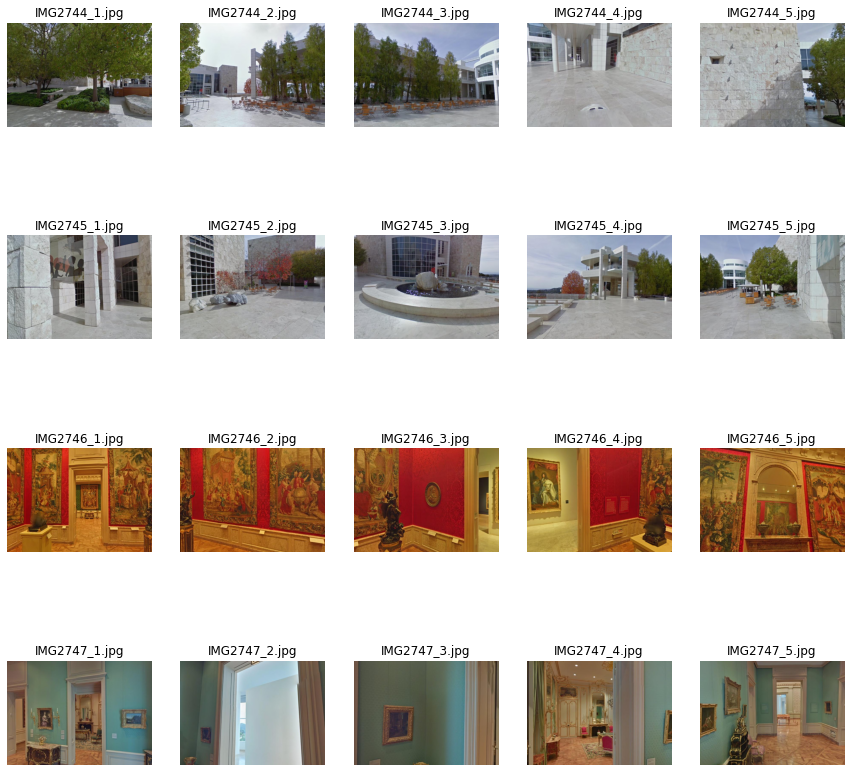

In [8]:
show_image(train_image[:20],train[:20],4,5)

In [8]:
trian_label = pd.read_csv("data/train.csv")
trian_label

,id,x,y
0,IMG2744_1,-9.380678,3.58272
1,IMG2744_2,-9.380678,3.58272
2,IMG2744_3,-9.380678,3.58272
3,IMG2744_4,-9.380678,3.58272
4,IMG2744_5,-9.380678,3.58272
...,...,...,...
7495,IMG4243_1,-4.680678,35.18272
7496,IMG4243_2,-4.680678,35.18272
7497,IMG4243_3,-4.680678,35.18272
7498,IMG4243_4,-4.680678,35.18272


In [9]:
# train_cluster = [name[:7] for name in train]
# trian_label["cluster"] = train_cluster
# trian_label.to_csv("data/with_cluster_train.csv")


In [12]:
grouped_label = trian_label.groupby("cluster")

In [13]:
x_label = []
cluser = []
y_label = []
for i,j in grouped_label:
    #print(i,j["x"])
    cluser.append(i)
    x_label.append(j["x"].iloc[0])
    y_label.append(j["y"].iloc[0])
    #print()

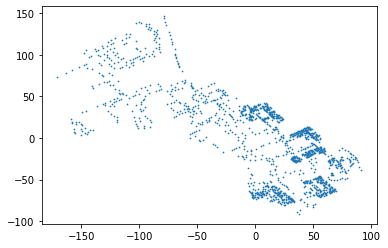

In [14]:
plt.scatter(x_label,y_label,s=0.5)
plt.show()

In [15]:
from sklearn.cluster import KMeans
import numpy as np

Coord = pd.DataFrame(x_label,y_label)

In [16]:
sse = []
for i in tqdm(range(2,20)):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(Coord)
    sse.append(kmeans.inertia_)

100%|██████████| 18/18 [00:00<00:00, 19.82it/s]


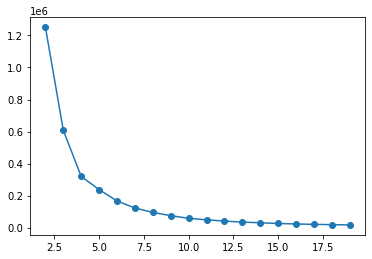

In [17]:
plt.plot(range(2,20),sse,"-o")
plt.show()

In [18]:
# 不同楼层 统一坐标
["IMG3663","IMG3254"]

['IMG3663', 'IMG3254']

In [8]:
sift = cv2.SIFT_create() 

In [9]:
kp_train = []
des_trian = []
for image in tqdm(train_image):
    kp, des = sift.detectAndCompute(image,None)
    kp_train.append(kp)
    des_trian.append(des)

100%|██████████| 7500/7500 [06:49<00:00, 18.33it/s]


In [10]:
kp_test = []
des_test = []
for image in tqdm(test_image):
    kp, des = sift.detectAndCompute(image,None)
    kp_test.append(kp)
    des_test.append(des)

100%|██████████| 1200/1200 [01:04<00:00, 18.66it/s]


In [24]:
# train_keypoint = pd.DataFrame({"image":train,"key_points":kp_train,"description":des_trian})
# test_keypoint = pd.DataFrame({"image":test,"key_points":kp_test,"description":des_test})

# train_keypoint.to_csv("data/train_keypoint.csv",index=False)
# test_keypoint.to_csv("data/test_keypoint.csv",index=False)

In [13]:
orb = cv2.ORB_create()

# Find keypoints and descriptors directly

In [14]:
kp_train_surf = []
des_trian_surf = []
for image in tqdm(train_image):
    kp, des = orb.detectAndCompute(image,None)
    kp_train_surf.append(kp)
    des_trian_surf.append(des)

100%|██████████| 7500/7500 [01:19<00:00, 94.09it/s] 


In [11]:
blank = []
for i in range(len(des_test)):
    try:
        len(des_test[i])
    except:
        blank.append(i)

print(blank)

[81, 360, 411, 828, 877, 1023, 1057, 1147]


In [12]:
test_index = [i for i in range(1200) if i not in blank]

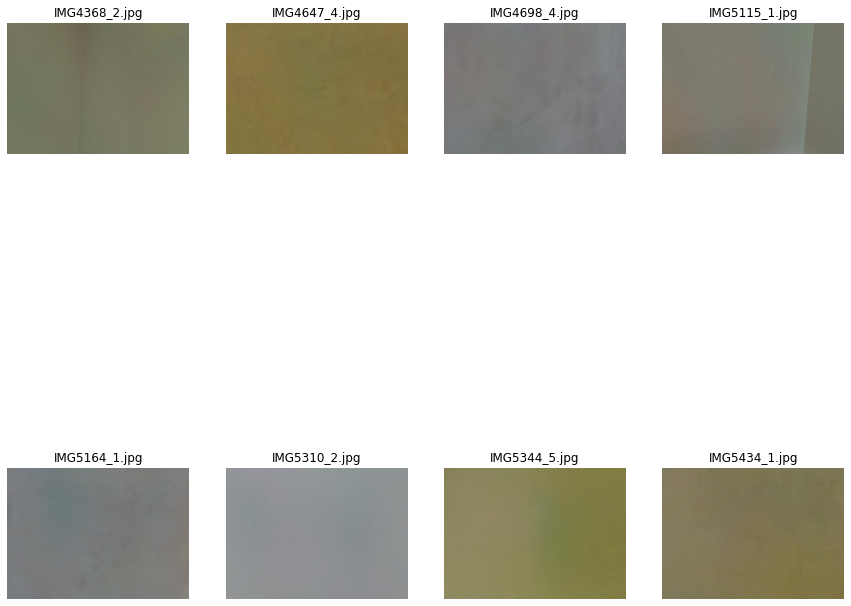

In [53]:
show_image(list(map(test_image.__getitem__, blank)),list(map(test.__getitem__, blank)),2,4)

In [13]:
# FLANN parameters and initialize
FLANN_INDEX_LINEAR = 0
FLANN_INDEX_KDTREE = 1
FLANN_INDEX_KMEANS = 2
FLANN_INDEX_COMPOSITE = 3
FLANN_INDEX_KDTREE_SINGLE = 4
FLANN_INDEX_HIERARCHICAL = 5
FLANN_INDEX_LSH = 6
FLANN_INDEX_SAVED = 254
FLANN_INDEX_AUTOTUNED = 255


In [14]:
index_params = dict(algorithm = FLANN_INDEX_HIERARCHICAL, trees = 5)
search_params = dict(checks=25)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)


# for i in range(1000):
#     flann.knnMatch(des_trian[i],des_test[0],k=2)

In [15]:
for i in range(10):
    flann.add([des_trian[i]])



In [16]:
flann.train()

In [17]:
print(len(flann.getTrainDescriptors()))

7500


In [21]:
matches = flann.knnMatch(des_trian[0],2)

In [38]:
 from collections import defaultdict

In [39]:
matches= flann.match(des_trian[0])


In [40]:
matches_dict = defaultdict(lambda : 0)

In [46]:
for f in matches:
    matches_dict[f.imgIdx]+=1
    temp = sorted(matches_dict.items(),key=lambda x:x[1],reverse=True)
    index = next(iter(temp))



In [47]:
list(index)[0]

0

In [43]:
print(train[list(index)[0]])

IMG2744_1.jpg


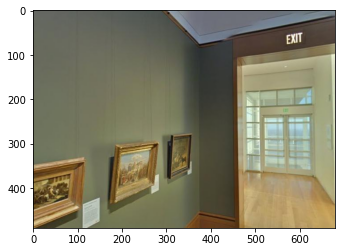

In [34]:
plt.imshow(test_image[0], cmap='gray')

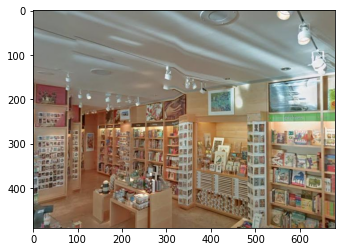

In [36]:
plt.imshow(train_image[2983], cmap='gray')

In [37]:
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8 *n.distance: # was 0.7
        print([m.queryIdx],[m.trainIdx])
        ptsL.append(kp1[m.queryIdx].pt)
        ptsR.append(kp2[m.trainIdx].pt)

[0] [0]
[1] [1]
[2] [2]
[3] [3]
[4] [4]
[5] [5]
[6] [6]
[7] [7]
[8] [8]
[9] [9]
[10] [10]
[11] [11]
[12] [12]
[13] [13]
[14] [14]
[15] [15]
[16] [16]
[17] [17]
[18] [18]
[19] [19]
[20] [20]
[21] [21]
[22] [22]
[23] [23]
[24] [24]
[25] [25]
[26] [26]
[27] [27]
[28] [28]
[29] [29]
[30] [30]
[31] [31]
[32] [32]
[33] [33]
[34] [34]
[35] [35]
[36] [36]
[37] [37]
[38] [38]
[39] [39]
[40] [40]
[41] [41]
[42] [42]
[43] [43]
[44] [44]
[45] [45]
[46] [46]
[47] [47]
[48] [48]
[49] [49]
[50] [50]
[51] [51]
[52] [52]
[53] [53]
[54] [54]
[55] [55]
[56] [56]
[57] [57]
[58] [58]
[59] [59]
[60] [60]
[61] [61]
[62] [62]
[63] [63]
[64] [64]
[65] [65]
[66] [66]
[67] [67]
[68] [68]
[69] [69]
[70] [70]
[71] [71]
[72] [72]
[73] [73]
[74] [74]
[75] [75]
[76] [76]
[77] [77]
[78] [78]
[79] [79]
[80] [80]
[81] [81]
[82] [82]
[83] [83]
[84] [84]
[85] [85]
[86] [86]
[87] [87]
[88] [88]
[89] [89]
[90] [90]
[91] [91]
[92] [92]
[93] [93]
[94] [94]
[95] [95]
[96] [96]
[97] [97]
[98] [98]
[99] [99]
[100] [100]
[101] [1

In [48]:
bf = cv2.BFMatcher()

# Match descriptors.


for i in range(1):
    for j in tqdm(test_index):
        matches = bf.knnMatch(des_trian[i],des_test[j],k=2)
        #matches = bf.Match(des_trian[i],des_test[j])

100%|██████████| 1192/1192 [00:21<00:00, 54.70it/s]


In [50]:
len(matches)

3397

In [37]:
for i in range(1):
    for j in tqdm(test_index):
        matches = bf.match(des_trian[i],des_test[j], k=2)

  0%|          | 0/1192 [00:00<?, ?it/s]


error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'match'
> Overload resolution failed:
>  - 'k' is an invalid keyword argument for DescriptorMatcher.match()
>  - 'k' is an invalid keyword argument for DescriptorMatcher.match()
>  - DescriptorMatcher.match() takes at most 2 arguments (3 given)
>  - DescriptorMatcher.match() takes at most 2 arguments (3 given)


In [58]:
matches = flann.knnMatch(des_trian[12],des_trian[13],k=2)

for m,n in matches[:10]:
    print(m.distance,n.distance)

184.94593811035156 235.705322265625
349.4381103515625 367.2056579589844
255.5934295654297 278.3702697753906
300.1532897949219 364.05767822265625
285.2332458496094 292.62091064453125
217.78659057617188 228.6656951904297
119.91664123535156 124.44275665283203
332.5762939453125 338.9100036621094
172.333984375 176.57009887695312
295.3269348144531 330.7022705078125


In [24]:
# 测试两个同样的location的图 能不能match到
matches = flann.knnMatch(des_trian[12],des_trian[13],k=2)

matchesMask = []

# Store all good matches as per Lowe's Ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        matchesMask.append([1,0]) # Match
    else:
        matchesMask.append([0,0]) # Mismatch
       
print("Good match:",len(good))
        
# Draw all good matches
draw_params = dict(#matchColor = (0,255,0),  #If you want a specific colour
                   #singlePointColor = (255,0,0), #If you want a specific colour
                    matchesMask = matchesMask,
                    flags = cv2.DrawMatchesFlags_DEFAULT)

good_matches = cv2.drawMatchesKnn(train_image[12],kp_train_surf[12],train_image[13],kp_train_surf[13],matches,None,**draw_params)


plt.figure(figsize=(15, 15))

plt.imshow(good_matches)
plt.title('All good matches')
plt.axis('off')

plt.show()

# 好像结果不太好的样子。。

NameError: name 'des_trian' is not defined

In [22]:
des_trian_surf[12]

array([[ 32, 249,  58, ...,  26, 198, 170],
       [ 32, 249, 184, ..., 154, 198, 171],
       [120,  56,  19, ...,  34,  38,  51],
       ...,
       [ 72, 177, 124, ..., 208, 198, 123],
       [120,  56,  58, ...,  12,  71, 122],
       [ 93,  49, 255, ..., 243, 131, 115]], dtype=uint8)

In [23]:
des_trian_surf[13]

array([[ 30, 207,  38, ..., 150, 253,  86],
       [ 49,  33, 168, ...,  74, 222,  10],
       [235,  23,  87, ..., 164, 104,  61],
       ...,
       [197, 236, 209, ..., 243, 163, 160],
       [106, 159,  66, ..., 254, 235, 217],
       [251, 201,  52, ...,  28, 169,  14]], dtype=uint8)

# Main color Detection

In [10]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

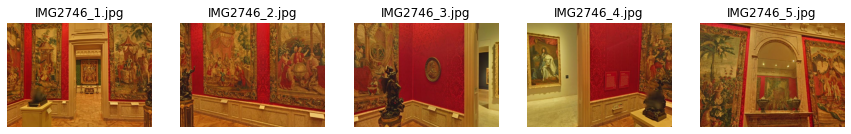

In [14]:
show_image(train_image[10:15],train[10:15],1,5)

In [15]:
def main_color(images,n_color,show = False):

    clf = KMeans(n_clusters = n_color)

    color_total = []
    weight_total = []

    for image in tqdm(images):
        modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
        flatten = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)

        labels = clf.fit_predict(flatten)

        counts = Counter(labels)

        center_colors = clf.cluster_centers_

        hex_colors = [RGB2HEX(center_colors[i]) for i in counts.keys()]

        color_total.append(center_colors)
        weight_total.append( [i/sum(counts.values()) for i in counts.values()])



        if show:
            plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
            plt.show()

    return color_total,weight_total

  0%|          | 0/5 [00:00<?, ?it/s]

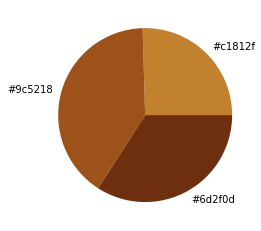

 20%|██        | 1/5 [00:01<00:07,  1.94s/it]

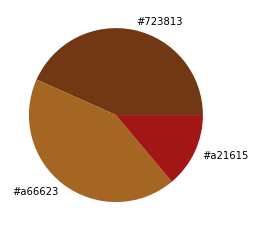

 40%|████      | 2/5 [00:03<00:05,  1.98s/it]

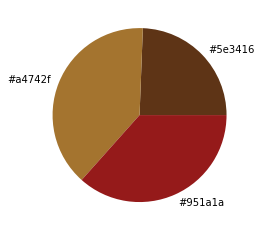

 60%|██████    | 3/5 [00:05<00:03,  1.70s/it]

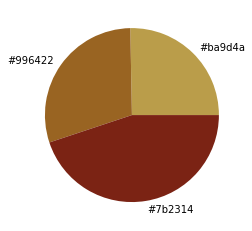

 80%|████████  | 4/5 [00:06<00:01,  1.60s/it]

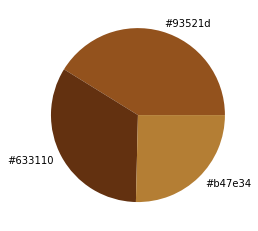

100%|██████████| 5/5 [00:08<00:00,  1.74s/it]


([array([[109.32640371,  47.94397429,  13.73104472],
         [156.00890715,  82.96557618,  24.05498749],
         [193.12657898, 129.47557577,  47.88541718]]),
  array([[114.19096872,  56.78989119,  19.5007923 ],
         [166.36285179, 102.27603222,  35.53676399],
         [162.22291235,  22.14555766,  21.71869655]]),
  array([[149.63369905,  26.23856664,  26.89726512],
         [ 94.86114325,  52.75530793,  22.12436203],
         [164.77432701, 116.93401612,  47.2204024 ]]),
  array([[153.41027365, 100.2512534 ,  34.08209394],
         [123.78642866,  35.10362199,  20.69625925],
         [186.5053118 , 157.51188988,  74.12192475]]),
  array([[180.88827584, 126.52769364,  52.79056632],
         [ 99.27877206,  49.88863355,  16.9009854 ],
         [147.9320904 ,  82.51094566,  29.1609578 ]])],
 [[0.25471666666666665, 0.4045666666666667, 0.34071666666666667],
  [0.4330375, 0.42816666666666664, 0.13879583333333334],
  [0.24395, 0.39010833333333333, 0.36594166666666667],
  [0.2529625, 0.

In [16]:
main_color(train_image[10:15],3,True)

In [16]:
color_total_train,weight_total_train = main_color(train_image,3)

100%|██████████| 7500/7500 [3:31:36<00:00,  1.69s/it]


In [19]:
trian_label["color"] = pd.Series(color_total_train)
trian_label["weight"] = pd.Series(weight_total_train)
trian_label.to_csv("data/with_color_train.csv")

In [12]:
color_total_test,weight_total_test = main_color(test_image,3)

100%|██████████| 1200/1200 [25:21<00:00,  1.27s/it]


In [14]:
test_label = pd.read_csv("data/imagenames.csv")

test_label["color"] = pd.Series(color_total_test)
test_label["weight"] = pd.Series(weight_total_test)


test_label.to_csv("data/with_color_test.csv")